In [7]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [8]:
# for data load
import os

# for reading and processing images
import imageio
from PIL import Image
import tifffile
# !pip install imagecodecs
import imagecodecs
import cv2

# for visualizations
import matplotlib.pyplot as plt

import numpy as np # for using np arrays
from numpy import asarray

# for bulding and running deep learning model
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.losses import binary_crossentropy
from sklearn.model_selection import train_test_split

## 1. UNDERSTAND THE DATA

In [9]:
def LoadData (path1):
    # Read the images folder like a list
    image_dataset = os.listdir(path1)

    # Make a list for images and masks filenames
    orig_img = []
    mask_img = []
    image_dataset.sort()
    for file in image_dataset:
        if file.endswith('_mask.tif'):
            mask_img.append(file)
            orig_img.append(file.replace("_mask.tif",".tif"))       

    # Sort the lists to get both of them in same order (the dataset has exactly the same name for images and corresponding masks)
    # orig_img.sort()
    # mask_img.sort()
    
    return orig_img, mask_img

(420, 580)
(420, 580)


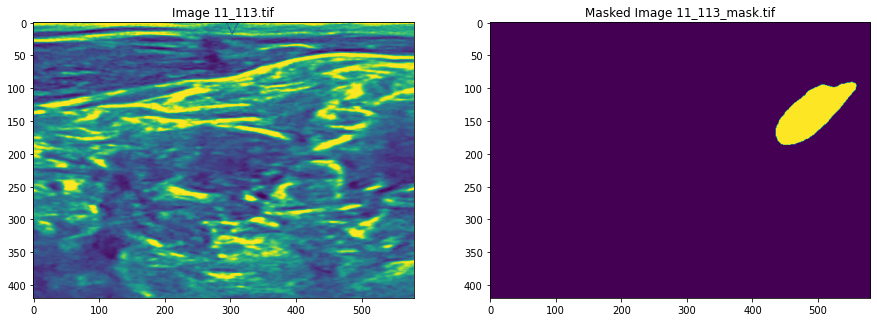

In [10]:
path1 = '../input/ultrasound-nerve-segmentation/train/'
img, mask = LoadData (path1)

show_images = 134

img_view  = imageio.imread(path1 + img[show_images])
mask_view = imageio.imread(path1 + mask[show_images])

print(img_view.shape)
print(mask_view.shape)
fig, arr = plt.subplots(1, 2, figsize=(15, 15))
arr[0].imshow(img_view)
arr[0].set_title('Image ' + img[show_images])
arr[1].imshow(mask_view)
arr[1].set_title('Masked Image '+ mask[show_images])
fig.savefig('full_figure.png')

In [11]:
def PreprocessData(img, mask, target_shape_img, target_shape_mask, path1, path2):
    """
    Processes the images and mask present in the shared list and path
    Returns a NumPy dataset with images as 3-D arrays of desired size
    Please note the masks in this dataset have only one channel
    """
    # Pull the relevant dimensions for image and mask
    m = len(img)                     # number of images
    i_h,i_w,i_c = target_shape_img   # pull height, width, and channels of image
    m_h,m_w,m_c = target_shape_mask  # pull height, width, and channels of mask
    
    # Define X and Y as number of images along with shape of one image
    X = np.zeros((m,i_h,i_w,i_c), dtype=np.float32)
    y = np.zeros((m,m_h,m_w,m_c), dtype=np.int32)
    
    # Resize images and masks
    for file in img:
        # convert image into an array of desired shape (3 channels)
        index = img.index(file)
        path = os.path.join(path1, file)
        single_img = Image.open(path).convert('RGB')
        single_img = single_img.resize((i_h,i_w))
        single_img = np.reshape(single_img,(i_h,i_w,i_c)) 
        single_img = single_img/256.
        X[index] = single_img
        
        # convert mask into an array of desired shape (1 channel)
        
        single_mask_ind = mask[index]
        path = os.path.join(path1, single_mask_ind)
        single_mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE) 
        single_mask = cv2.resize(single_mask, dsize=(m_h, m_w), interpolation=cv2.INTER_NEAREST)
        single_mask = asarray(single_mask)
        single_mask = single_mask[..., tf.newaxis]
        single_mask = np.reshape(single_mask,(m_h,m_w,m_c)) 
        single_mask = single_mask/255
        single_mask = single_mask.astype(int) 
        y[index] = single_mask
    return X, y

X Shape: (5635, 256, 256, 3)
Y shape: (5635, 256, 256, 1)
[0 1]


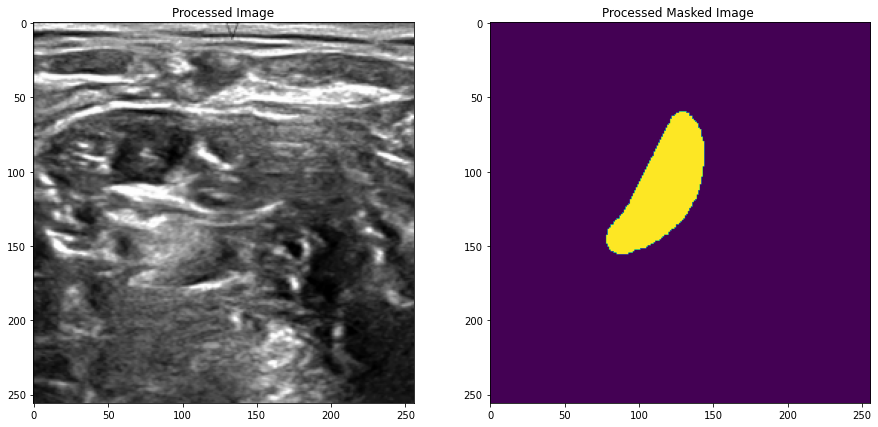

In [12]:
# Define the desired shape
target_shape_img = [256, 256, 3]
target_shape_mask = [256, 256, 1]

# Process data using apt helper function

X, y = PreprocessData(img, mask, target_shape_img, target_shape_mask, path1, path1)

# QC the shape of output and classes in output dataset 
print("X Shape:", X.shape)
print("Y shape:", y.shape)
# There are 2 classes
print(np.unique(y))

# Visualize the output
image_index = 0
fig, arr = plt.subplots(1, 2, figsize=(15, 15))
arr[0].imshow(X[image_index])
arr[0].set_title('Processed Image')
arr[1].imshow(y[image_index,:,:,0])
arr[1].set_title('Processed Masked Image ')
fig.savefig('full_figure_2.png')

## 2. UNET MODELING

In [13]:
def EncoderMiniBlock(inputs, n_filters=32, dropout_prob=0.3, max_pooling=True):
    """
    This block uses multiple convolution layers, max pool, relu activation to create an architecture for learning. 
    Dropout can be added for regularization to prevent overfitting. 
    The block returns the activation values for next layer along with a skip connection which will be used in the decoder
    """
    # Add 2 Conv Layers with relu activation and HeNormal initialization using TensorFlow 
    # Proper initialization prevents from the problem of exploding and vanishing gradients 
    # 'Same' padding will pad the input to conv layer such that the output has the same height and width (hence, is not reduced in size) 
    conv = Conv2D(n_filters, 
                  3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(inputs)
    conv = Conv2D(n_filters, 
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(conv)
    
    # Batch Normalization will normalize the output of the last layer based on the batch's mean and standard deviation
    conv = BatchNormalization()(conv, training=False)

    # In case of overfitting, dropout will regularize the loss and gradient computation to shrink the influence of weights on output
    if dropout_prob > 0:     
        conv = tf.keras.layers.Dropout(dropout_prob)(conv)

    # Pooling reduces the size of the image while keeping the number of channels same
    # Pooling has been kept as optional as the last encoder layer does not use pooling (hence, makes the encoder block flexible to use)
    # Below, Max pooling considers the maximum of the input slice for output computation and uses stride of 2 to traverse across input image
    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(conv)    
    else:
        next_layer = conv

    # skip connection (without max pooling) will be input to the decoder layer to prevent information loss during transpose convolutions      
    skip_connection = conv
    
    return next_layer, skip_connection

In [14]:
def DecoderMiniBlock(prev_layer_input, skip_layer_input, n_filters=32):
    """
    Decoder Block first uses transpose convolution to upscale the image to a bigger size and then,
    merges the result with skip layer results from encoder block
    Adding 2 convolutions with 'same' padding helps further increase the depth of the network for better predictions
    The function returns the decoded layer output
    """
    # Start with a transpose convolution layer to first increase the size of the image
    up = Conv2DTranspose(
                 n_filters,
                 (3,3),    # Kernel size
                 strides=(2,2),
                 padding='same')(prev_layer_input)

    # Merge the skip connection from previous block to prevent information loss
    merge = concatenate([up, skip_layer_input], axis=3)
    
    # Add 2 Conv Layers with relu activation and HeNormal initialization for further processing
    # The parameters for the function are similar to encoder
    conv = Conv2D(n_filters, 
                 3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(merge)
    conv = Conv2D(n_filters,
                 3,   # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(conv)
    return conv

In [15]:
def UNetCompiled(input_size=(256, 256, 3), n_filters=32, n_classes=2):
    inputs = Input(input_size)

    # Encoder includes multiple convolutional mini blocks with different maxpooling, dropout and filter parameters
    # Observe that the filters are increasing as we go deeper into the network which will increasse the # channels of the image 
    cblock1 = EncoderMiniBlock(inputs, n_filters,dropout_prob=0, max_pooling=True)
    cblock2 = EncoderMiniBlock(cblock1[0],n_filters*2,dropout_prob=0, max_pooling=True)
    cblock3 = EncoderMiniBlock(cblock2[0], n_filters*4,dropout_prob=0, max_pooling=True)
    cblock4 = EncoderMiniBlock(cblock3[0], n_filters*8,dropout_prob=0.3, max_pooling=True)
    cblock5 = EncoderMiniBlock(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False) 

    # Decoder includes multiple mini blocks with decreasing number of filters
    # Observe the skip connections from the encoder are given as input to the decoder
    # Recall the 2nd output of encoder block was skip connection, hence cblockn[1] is used
    ublock6 = DecoderMiniBlock(cblock5[0], cblock4[1],  n_filters * 8)
    ublock7 = DecoderMiniBlock(ublock6, cblock3[1],  n_filters * 4)
    ublock8 = DecoderMiniBlock(ublock7, cblock2[1],  n_filters * 2)
    ublock9 = DecoderMiniBlock(ublock8, cblock1[1],  n_filters)

    # Complete the model with 1 3x3 convolution layer (Same as the prev Conv Layers)
    # Followed by a 1x1 Conv layer to get the image to the desired size. 
    # Observe the number of channels will be equal to number of output classes
    conv9 = Conv2D(n_filters,
                3,
                activation='relu',
                padding='same',
                kernel_initializer='he_normal')(ublock9)

    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)

    # Define the model
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [16]:
# Use scikit-learn's function to split the dataset
# Here, I have used 20% data as test/valid set
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=123)

# Call the helper function for defining the layers for the model, given the input image size
unet = UNetCompiled(input_size=(256,256,3), n_filters=32, n_classes=2)

# Check the summary to better interpret how the output dimensions change in each layer
unet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv2d_1[0][0]                   
______________________________________________________________________________________________

In [17]:
# There are multiple optimizers, loss functions and metrics that can be used to compile multi-class segmentation models
# Ideally, try different options to get the best accuracy
unet.compile(optimizer=tf.keras.optimizers.Adam(), 
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
# Run the model in a mini-batch fashion and compute the progress for each epoch
results = unet.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
141/141 [==============================] - 71s 417ms/step - loss: 0.0716 - accuracy: 0.9806 - val_loss: 0.0439 - val_accuracy: 0.9876
Epoch 2/20
141/141 [==============================] - 52s 367ms/step - loss: 0.0392 - accuracy: 0.9880 - val_loss: 0.0372 - val_accuracy: 0.9876
Epoch 3/20
141/141 [==============================] - 52s 366ms/step - loss: 0.0322 - accuracy: 0.9886 - val_loss: 0.0302 - val_accuracy: 0.9897
Epoch 4/20
141/141 [==============================] - 52s 366ms/step - loss: 0.0261 - accuracy: 0.9904 - val_loss: 0.0297 - val_accuracy: 0.9897
Epoch 5/20
141/141 [==============================] - 52s 366ms/step - loss: 0.0241 - accuracy: 0.9911 - val_loss: 0.0259 - val_accuracy: 0.9906
Epoch 6/20
141/141 [==============================] - 52s 366ms/step - loss: 0.0237 - accuracy: 0.9912 - val_loss: 0.0253 - val_accuracy: 0.9907
Epoch 7/20
141/141 [==============================] - 52s 366ms/step - loss: 0.0220 - accuracy: 0.9916 - val_loss: 0.0249 - val_ac

## 3. PREDICTIONS

In [18]:
## predict test set
path2 = '../input/ultrasound-nerve-segmentation/test/'
image_dataset = os.listdir(path2)
test_img = []
for file in image_dataset:
    test_img.append(file)

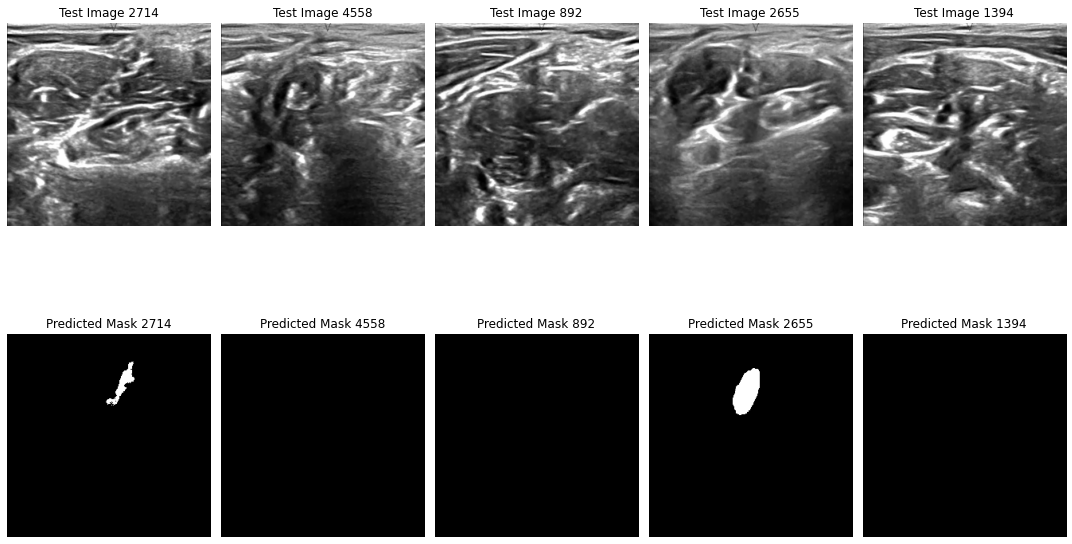

In [19]:
# create a table with X and Y

m = len(test_img)                     # number of images
i_h,i_w,i_c = target_shape_img   # pull height, width, and channels of image

# Define X and Y as number of images along with shape of one image
test_X = np.zeros((m,i_h,i_w,i_c), dtype=np.float32)

# Resize images and masks
for file in test_img:
    # convert image into an array of desired shape (3 channels)
    index = test_img.index(file)
    path = os.path.join(path2, file)
    single_img = Image.open(path).convert('RGB')
    single_img = single_img.resize((i_h,i_w))
    single_img = np.reshape(single_img,(i_h,i_w,i_c)) 
    single_img = single_img/256.
    test_X[index] = single_img
    

# predict masks
test_y = []
for img in test_X:
    img = img[np.newaxis, ...]
    pred_y = unet.predict(img)
    pred_mask = tf.argmax(pred_y[0], axis=-1)
    test_y.append(pred_mask)
    
import numpy as np
import matplotlib.pyplot as plt

# predict masks
test_y = []
for img in test_X:
    img = img[np.newaxis, ...]
    pred_y = unet.predict(img)
    pred_mask = tf.argmax(pred_y[0], axis=-1)
    test_y.append(pred_mask)

# Select a few images and their predicted masks from the test set
num_samples_to_visualize = 5
selected_indices = np.random.choice(len(test_X), num_samples_to_visualize, replace=False)

# Plot the images along with their predicted masks
plt.figure(figsize=(15, 10))

for i, idx in enumerate(selected_indices, 1):
    plt.subplot(2, num_samples_to_visualize, i)
    plt.imshow(test_X[idx])
    plt.title(f'Test Image {idx}')
    plt.axis('off')

    plt.subplot(2, num_samples_to_visualize, i + num_samples_to_visualize)
    plt.imshow(test_y[idx], cmap='gray')
    plt.title(f'Predicted Mask {idx}')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [20]:
def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

In [21]:
import pandas as pd
test_output = pd.DataFrame(columns = ['img','pixels'])

for i,item in enumerate(test_y):
    encoding = rle_encoding(item.numpy())
    pixels = ' '.join(map(str, encoding))
    df = {'img': test_img[i][:-4], 'pixels': pixels}
    test_output = test_output.append(df, ignore_index = True)

test_output

,img,pixels
0,1259,
1,659,26220 1 26222 1 26225 1 26228 1 26470 15 26723...
2,4794,36439 1 36695 1 36705 1 36707 2 36951 1 36963 ...
3,274,31564 8 31818 14 32071 23 32323 31 32571 41 32...
4,315,41584 1 41594 2 41836 6 41849 4 42084 15 42104...
...,...,...
5503,474,
5504,4056,
5505,3842,35916 1 35918 3 35922 4 36164 1 36166 32 36416...
5506,2681,


In [22]:
test_output.to_csv('/kaggle/working/submission.csv', index=False)

In [23]:
history = results.history
print(history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


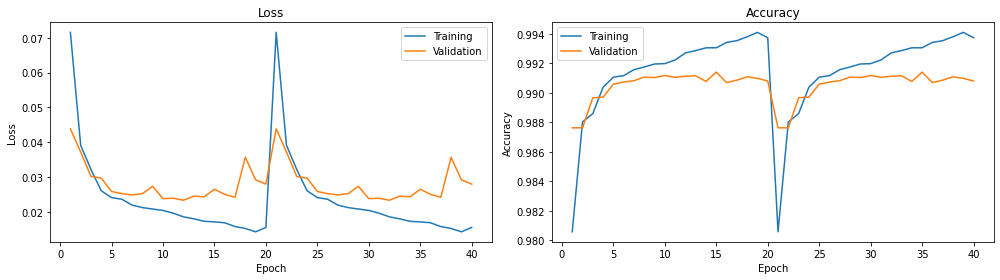

<Figure size 432x288 with 0 Axes>

In [24]:

for k in history.keys():
    history[k] += results.history[k]

epoch_range = range(1, len(history['loss'])+1)


plt.figure(figsize=[14,4])
plt.subplot(1,2,1)
plt.plot(epoch_range, history['loss'], label='Training')
plt.plot(epoch_range, history['val_loss'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epoch_range, history['accuracy'], label='Training')
plt.plot(epoch_range, history['val_accuracy'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()
plt.savefig('results.png')

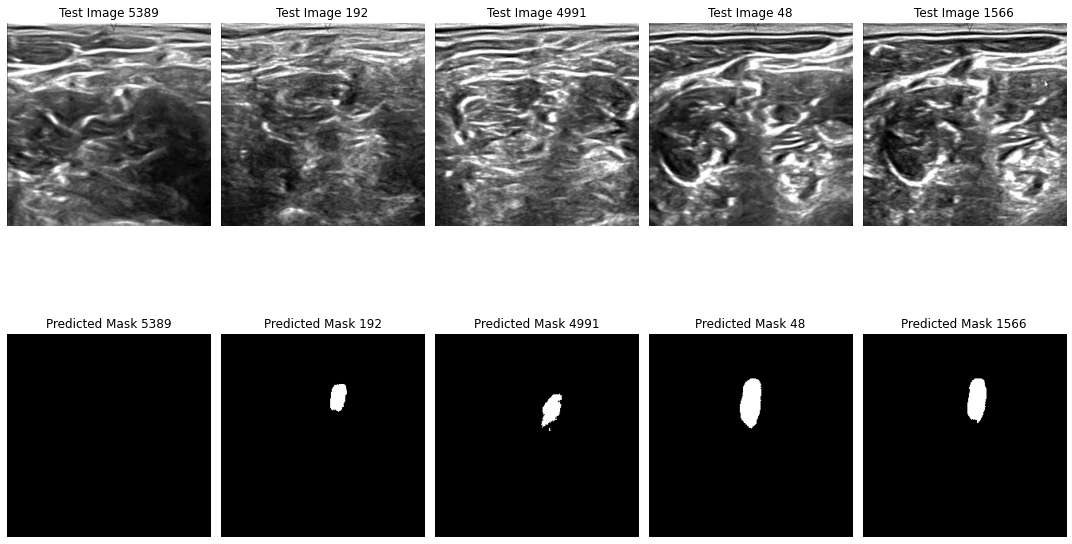

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# predict masks
test_y = []
for img in test_X:
    img = img[np.newaxis, ...]
    pred_y = unet.predict(img)
    pred_mask = tf.argmax(pred_y[0], axis=-1)
    test_y.append(pred_mask)

# Select a few images and their predicted masks from the test set
num_samples_to_visualize = 5
selected_indices = np.random.choice(len(test_X), num_samples_to_visualize, replace=False)

# Plot the images along with their predicted masks
plt.figure(figsize=(15, 10))

for i, idx in enumerate(selected_indices, 1):
    plt.subplot(2, num_samples_to_visualize, i)
    plt.imshow(test_X[idx])
    plt.title(f'Test Image {idx}')
    plt.axis('off')

    plt.subplot(2, num_samples_to_visualize, i + num_samples_to_visualize)
    plt.imshow(test_y[idx], cmap='gray')
    plt.title(f'Predicted Mask {idx}')
    plt.axis('off')

plt.tight_layout()
plt.show()
